In [114]:
import torch
import numpy as np
from skimage import io, transform
from torchvision import transforms
from torch.utils.data import DataLoader
from datasets import SubtitleSegmentationDataset
from transforms import Rescale, ToTensor
from models import BaselineModel, SubtitleSegmentation
from tqdm.notebook import tqdm

In [8]:
# Setup device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [20]:
width, height = 640, 360

In [92]:
baseline = BaselineModel(in_channels=3, height=height, width=width).to(device)
baseline.load_state_dict(torch.load("trained-models/baseline.torch", map_location=device))

subseg = SubtitleSegmentation(in_channels=3, height=height, width=width).to(device)
subseg.load_state_dict(torch.load("trained-models/subseg.torch", map_location=device))

<All keys matched successfully>

In [102]:
frame = io.imread("data/test/subs/03.png")
image = transform.resize(frame, (height, width))
image = image / image.max()
image = image.transpose(2, 0, 1)
image = image[None, ...]
image = torch.tensor(image).float().to(device)

In [98]:
def segment(model, image):
    mask, has_subtitle = model(image)
    mask = (mask > 0.5).float()
    mask = mask.detach().cpu().numpy() * 255
    mask = np.array(mask, np.uint8)
    return mask

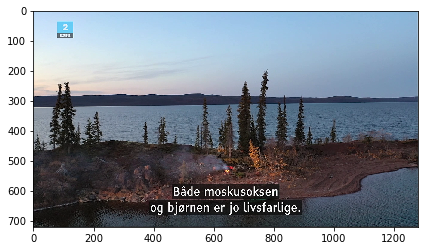

In [103]:
io.imshow(frame)
io.show()

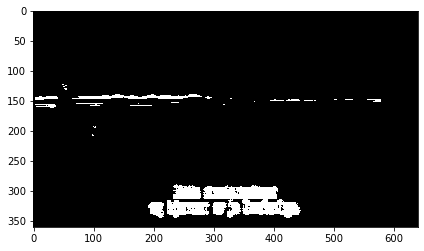

In [100]:
mask = segment(baseline, image)
io.imshow(mask[0, 0])
io.show()

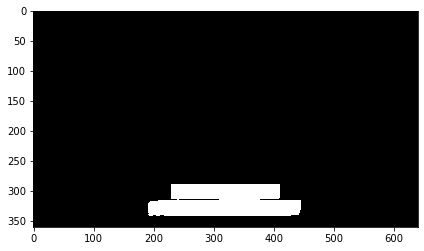

In [99]:
mask = segment(subseg, image)
io.imshow(mask[0, 0])
io.show()

In [117]:
test_dataset = SubtitleSegmentationDataset("data/test", 
                                           transform=transforms.Compose([Rescale((360, 640)), ToTensor()]))
test_dataloader = DataLoader(test_dataset, batch_size=1, num_workers=1)

In [118]:
def test_perf(model):
    model.eval()
    test_loss = []
    has_subtitle_accuracy = []
    mask_accuracy = []
    mask_f1 = []
    mask_precision = []
    mask_recall = []

    test_dataloader_tqdm = tqdm(test_dataloader)
    for batch in test_dataloader_tqdm:
        image = batch["image"].float().to(device)
        mask = batch["mask"].float().to(device)
        has_subtitle = batch["has_subtitle"].float().to(device)
        pred_mask, pred_has_subtitle = model(image)
        has_subtitle_accuracy.append(1 if (pred_has_subtitle.item() > 0.5) == has_subtitle else 0)

        if has_subtitle.item():
            true_positive = torch.sum(pred_mask[mask == True] >= 0.5).float()
            false_positive = torch.sum(pred_mask[mask == False] >= 0.5).float()
            false_negative = torch.sum(pred_mask[mask == True] < 0.5).float()

            precision = true_positive / (true_positive + false_positive)
            recall = true_positive / (true_positive + false_negative)
            f1 = 1 / (0.5 * (1 / recall + 1 / precision))

            mask_precision.append(precision.item())
            mask_recall.append(recall.item())
            mask_f1.append(f1.item())

    print(f"Has subtitle accuracy: {np.mean(has_subtitle_accuracy)}")
    print(f"Mask precision: {np.mean(mask_precision)}")
    print(f"Mask recall: {np.mean(mask_recall)}")
    print(f"Mask f1: {np.mean(mask_f1)}")

In [120]:
test_perf(baseline)


Has subtitle accuracy: 0.993006993006993
Mask precision: 0.9778908242153216
Mask recall: 0.8471016898939882
Mask f1: 0.9071427976028829


In [119]:
test_perf(subseg)


Has subtitle accuracy: 1.0
Mask precision: 0.9968307576602018
Mask recall: 0.9949159388300739
Mask f1: 0.9958226824108558
